In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
from functools import partial, reduce
from operator import mul
import numpy as np
sns.set()

In [9]:
%precision 4

'%.4f'

In [10]:
y_history_points = [1.7777, 4.5634, 13.8436, 37.3387, 72.3593]
x_history_points = [1.3, 2.1, 3.7, 6.1, 8.5]
x = 4.5
actual_func = lambda x: 1/x*math.log10(x)+x**2

# Lagrange interpolation

In [11]:
class LagrangeInterpolation:
    def __init__(self, x_history_points, y_history_points):
        self.x_history_points = x_history_points
        self.y_history_points = y_history_points
        self.interpolated_func = self.__interpolate_func()
        
    def __interpolate_func(self):
        # building a nested function which is a composite of other functions
        list_to_sum_up = []
        for i in range(len(self.y_history_points)):
            funcs = []
            for j in range(len(self.y_history_points)):
                if i!=j:
                    func = lambda x, x_j, x_i: (x-x_j)/(x_i-x_j)
                    func = partial(func, x_j=self.x_history_points[j], x_i=self.x_history_points[i])
                    funcs.append(func)
            L = lambda x, y_i, funcs: y_i*reduce(mul,[func(x=x) for func in funcs])    
            L = partial(L, y_i=self.y_history_points[i], funcs=funcs)
            list_to_sum_up.append(L)
        interpolated_func = lambda x: sum([func(x=x) for func in list_to_sum_up])
        return interpolated_func
    
    def interpolate(self, x):
        # inteprolation for single point
        return self.interpolated_func(x)
    
    def get_interpolated_curve(self):
        # interpolation for whole curve
        y_interpolated = [self.interpolated_func(i) for i in self.x_history_points]
        return self.x_history_points, y_interpolated
    
    def get_initial_curve(self):
        # getting intial curve
        return self.x_history_points, self.y_history_points
    
    def error_in_point(self, initial_func, x):
        # calculating error in point
        return abs(initial_func(x)-self.interpolated_func(x))

In [12]:
interpolation_cls = LagrangeInterpolation(x_history_points, y_history_points)

In [13]:
print(f'Interpolated value for x={x} is y={interpolation_cls.interpolate(x)}')

Interpolated value for x=4.5 is y=20.386783333333334


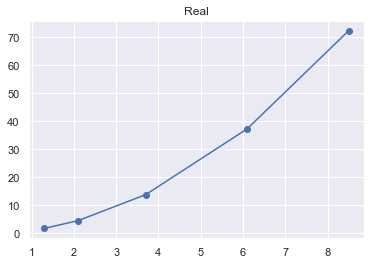

In [14]:
plt.plot(*interpolation_cls.get_initial_curve(), '-o', color='b');
plt.title('Real');

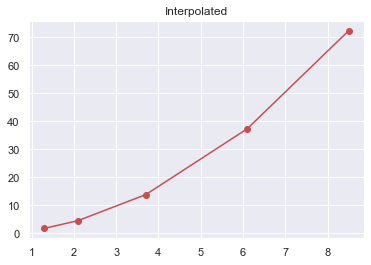

In [15]:
plt.plot(*interpolation_cls.get_interpolated_curve(), '-o', color='r')
plt.title('Interpolated');

In [16]:
print(f'Actual error : {interpolation_cls.error_in_point(actual_func, x)}')

Actual error : 0.008375003061185993


# Computing theoretical error

In [17]:
A = reduce(mul,[abs(x-i) for i in x_history_points])

In [18]:
A

39.3216

In [19]:
n = len(x_history_points)-1
print(n)
B = reduce(mul,range(1,n+2))

4


In [20]:
B

120

In [21]:
K = A/B

In [22]:
K

0.3277

In [23]:
f = lambda x: 2*math.log(10)*(3*(math.log(x)**4)+5*(math.log(x)**3)-15*(math.log(x)**2)-60*math.log(x)-60)/(x**4*(math.log(x)**6))
# fifth derivative

In [24]:
M = lambda f: max([abs(f(i)) for i in x_history_points])

In [25]:
print("Theoretical error : {}".format(K*M(f)))

Theoretical error : 124199.2095887773


# Newtons interpolation

In [84]:
class NewtonsInterpolation:
    def __init__(self,  x_history_points, y_history_points):
        self.x_history_points = x_history_points
        self.y_history_points = y_history_points
        
        self.fin_diff = self._compute_finite_differences()
        
    def _compute_finite_differences(self):
        fin_diff = [] 
        y = self.y_history_points
        for j in range(len(y)-1):
            arr = []
            for i in range(len(y)-1):
                arr.append(y[i+1]-y[i])
            y = arr
            fin_diff.append(arr)
        return fin_diff
    
    def compute_q_forward(self,x,h, N):
        q = (x-self.x_history_points[0])/h
        qs = [q-i+1 for i in range(1,N+1)]
        qs = [reduce(mul,qs[:i]) for i in range(1, N+1)]
        return qs
        
    def compute_q_backward(self,x,h, N):
        q =  (x-self.x_history_points[-1])/h
        qs = [q+i-1 for i in range(1, N+1)]
        qs = [reduce(mul,qs[:i]) for i in range(1, N+1)]
        return qs
    
    def interpolate_func_forward(self, x, h=None):
        if not h:
            h = self.x_history_points[1]-self.x_history_points[0]
        interpolated = self.y_history_points[0]
        N = len(self.y_history_points)-1
        qs = self.compute_q_forward(x, h, N)
        for i in range(N):
            N_factorial = reduce(mul,range(1,i+2))
            interpolated=interpolated+(self.fin_diff[i][0]/N_factorial)*qs[i]
        return interpolated
    
    def interpolate_func_backward(self, x, h=None):
        if not h:
            h = self.x_history_points[1]-self.x_history_points[0]
        interpolated = self.y_history_points[-1]
        N = len(self.y_history_points)-1
        qs = self.compute_q_backward(x, h, N)
        for c,i in enumerate(range(N)[::-1]):
            N_factorial = reduce(mul,range(1,c+2))
            interpolated=interpolated+(self.fin_diff[c][i]/N_factorial)*qs[i]
        return interpolated

In [118]:
newtons_interpolation = NewtonsInterpolation(x_history_points, 
                                            y_history_points)

In [119]:
pred_forward = [newtons_interpolation.interpolate_func_forward(i, h=None) for i in x_history_points]

In [138]:
pred_forward

[1.7777, 4.5634, 37.3387, 114.1704, -402.4702]

In [139]:
pred_backward

[103041.8586, 56949.0522, 11977.4007, 36.3946, 72.3593]

In [133]:
pred_backward = [newtons_interpolation.interpolate_func_backward(i, h=None) for i in x_history_points]

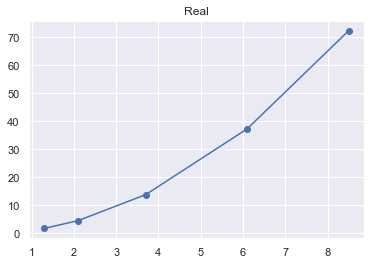

In [134]:
plt.plot(x_history_points,y_history_points, '-o', color='b');
plt.title('Real');

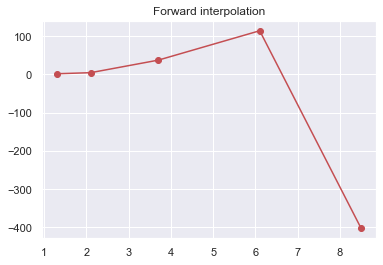

In [135]:
plt.plot(x_history_points,pred_forward, '-o', color='r');
plt.title('Forward interpolation');

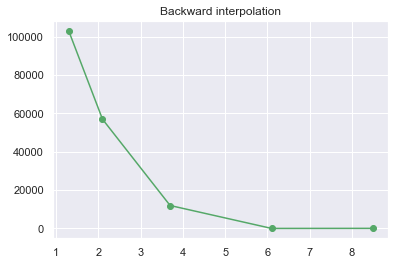

In [136]:
plt.plot(x_history_points, pred_backward, '-o', color='g');
plt.title('Backward interpolation');

In [137]:
y_history_points

[1.7777, 4.5634, 13.8436, 37.3387, 72.3593]

In [77]:
newtons_interpolation.interpolate_func_backward(x, h=x_history_points[-1]-x_history_points[-2])

92.0126

### test cases

In [95]:
# cases were retrived from here https://atozmath.com/example/CONM/NumeInterPola.aspx?he=e&q=A

In [102]:
forward_case1 = {"x_hist": [1891,
1901,
1911,
1921,
1931,], "y_hist": [46,66,81,93,101], "to_interp":1895, "real":54.8528}
forward_case2 = {"x_hist": [0,1,2,3], "y_hist": [1,0,1,10], "to_interp":-1, "real":-2}

#### case 1 forward

In [92]:
newtons_interpolation = NewtonsInterpolation(forward_case1['x_hist'], 
                                            forward_case1['y_hist'])

In [101]:
forward_case1['real']-newtons_interpolation.interpolate_func_forward(forward_case1['to_interp'])

0.0000

In [98]:
forward_pred = [newtons_interpolation.interpolate_func_forward(i) for i in forward_case1['x_hist']]

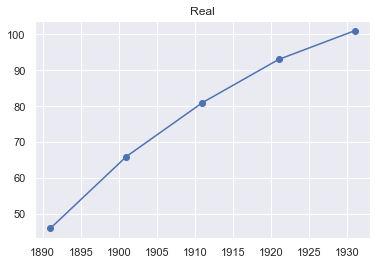

In [97]:
plt.plot(forward_case1['x_hist'],forward_case1['y_hist'], '-o', color='b');
plt.title('Real');

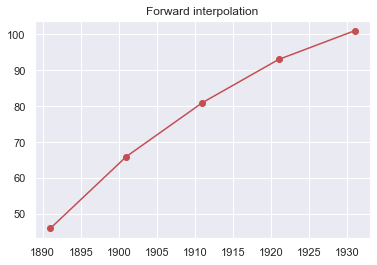

In [100]:
plt.plot(forward_case1['x_hist'],forward_pred , '-o', color='r');
plt.title('Forward interpolation');

#### case 2 forward

In [103]:
newtons_interpolation = NewtonsInterpolation(forward_case2['x_hist'], 
                                            forward_case2['y_hist'])

In [107]:
forward_pred = [newtons_interpolation.interpolate_func_forward(i) for i in forward_case2['x_hist']]

In [104]:
forward_case2['real']-newtons_interpolation.interpolate_func_forward(forward_case2['to_interp'])

0.0000

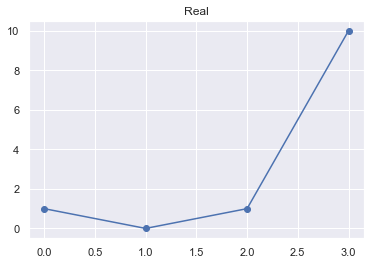

In [105]:
plt.plot(forward_case2['x_hist'],forward_case2['y_hist'], '-o', color='b');
plt.title('Real');

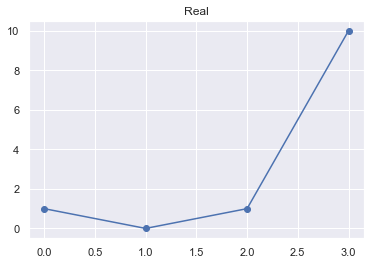

In [108]:
plt.plot(forward_case2['x_hist'],forward_pred, '-o', color='b');
plt.title('Real');